# Distributed K-Means

### Authors
- Bezzi Filippo, *2148867*, filippo.bezzi@studenti.unipd.it
- Conte William, *2139490*, william.conte@studenti.unipd.it
- D'Amore Edoardo, *2152861*, edoardo.damore@studenti.unipd.it
- Gasparotto Giacomo, *2156362*, giacomo.gasparotto@studenti.unipd.it

In [ ]:
import numpy as np
import numpy.typing as npt
import os
import pandas as pd
import time

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
import matplotlib.cm as cm
import seaborn as sns

from functools import singledispatch
import warnings
import logging

# dataset
from sklearn.datasets import fetch_kddcup99
from sklearn.preprocessing import StandardScaler

# pyspark module
from pyspark.rdd import RDD

# src module
from src.utils import *
from src.data import *
from src.kmeans.base import *
from src.kmeans.initialization import *
from src.kmeans.update import *

Starting the cluster

In [2]:
"""# creating the zipped environment if it doesn't already exist
! if [ ! -f "environment.tar.gz" ]; then venv-pack -o "environment.tar.gz" ; fi
# creating the zipped module src
! if [ -f "src.tar.gz" ]; then rm src.tar.gz ; fi
! tar -czf src.tar.gz src"""

'# creating the zipped environment if it doesn\'t already exist\n! if [ ! -f "environment.tar.gz" ]; then venv-pack -o "environment.tar.gz" ; fi\n# creating the zipped module src\n! if [ -f "src.tar.gz" ]; then rm src.tar.gz ; fi\n! tar -czf src.tar.gz src'

In [3]:
"""# starting the cluster
! $SPARK_HOME/sbin/start-all.sh"""

'# starting the cluster\n! $SPARK_HOME/sbin/start-all.sh'

master: starting org.apache.spark.deploy.worker.Worker, logging to /usr/local/spark/logs/spark-ubuntu-org.apache.spark.deploy.worker.Worker-1-mapd-b-14-1.out
worker3: starting org.apache.spark.deploy.worker.Worker, logging to /usr/local/spark/logs/spark-ubuntu-org.apache.spark.deploy.worker.Worker-1-mapd-b-14-4.out
worker2: starting org.apache.spark.deploy.worker.Worker, logging to /usr/local/spark/logs/spark-ubuntu-org.apache.spark.deploy.worker.Worker-1-mapd-b-14-3.out
worker1: starting org.apache.spark.deploy.worker.Worker, logging to /usr/local/spark/logs/spark-ubuntu-org.apache.spark.deploy.worker.Worker-1-mapd-b-14-2.out


In [4]:
"""os.environ["PYSPARK_PYTHON"] = "./environment/bin/python"""

'os.environ["PYSPARK_PYTHON"] = "./environment/bin/python'

In [5]:
"""# creating a sparkSession
spark = sparkSetup("kMeans")
sc = spark.sparkContext
# exporting the src module
sc.addPyFile("src.tar.gz")
sc.setLogLevel("ERROR")
# Setup the spark warnings
# log4j_conf_path = "./config/log4j.properties"
# warnings.filterwarnings("ignore") 
# logging.getLogger('py4j').setLevel(logging.ERROR) 
# logging.getLogger('pyspark').setLevel(logging.ERROR) """

'# creating a sparkSession\nspark = sparkSetup("kMeans")\nsc = spark.sparkContext\n# exporting the src module\nsc.addPyFile("src.tar.gz")\nsc.setLogLevel("ERROR")\n# Setup the spark warnings\n# log4j_conf_path = "./config/log4j.properties"\n# warnings.filterwarnings("ignore") \n# logging.getLogger(\'py4j\').setLevel(logging.ERROR) \n# logging.getLogger(\'pyspark\').setLevel(logging.ERROR) '

In [6]:
# Setup the spark warnings
warnings.filterwarnings("ignore") 
logging.getLogger('py4j').setLevel(logging.ERROR) 
logging.getLogger('pyspark').setLevel(logging.ERROR) 
log4j_conf_path = "./Settings//log4j.properties"

In [7]:
### DOCKER VERSION
from pyspark.sql import SparkSession

spark = (SparkSession.builder 
        .appName("kMeans") 
        .master("spark://spark-master:7077") 
        .config("spark.driver.memory", "4g") 
        .config("spark.executor.memory", "4g") 
        .config("spark.executor.cores", "2") 
        .config("spark.cores.max", "8") 
        .config("spark.network.timeout", "600s")   
        .config("spark.executor.heartbeatInterval", "60s") 
        .getOrCreate()
        )
sc = spark.sparkContext
sc.setLogLevel("ERROR")

sc.addPyFile("src.zip")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/15 10:11:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Load and Test datasets

## Gaussian Mixture

The first dataset we would consider to test the performance of the k-means++ initialization algorithm is a synthetic GaussMixture. To generate it, we sampled $k$ centers from a 15-dimensional spherical Gaussian distribution with mean at the origin and variance $R\in \{1,10,100\}$. We then added points from Gaussian distributions of unit variance around each center. Given the $k$ centers, this is a mixture of $k$ spherical Gaussians with equal weights. The value of the optimal k-clustering
can be well approximated using the centers of these Gaussians.

We will perform some preliminary analysis that can be efficiently conducted on this dataset.

# kMeans|| Init Tests

## Time / Cost tables

The first thing we want to assess with this dataset is the performance in terms of time and cost using different initialization algorithms. In particular, we chose to initialize our k-means algorithm with four different methods:

- **random**;
- **k-means++**;
- **k-means||** with $l\cdot k = 0.5$;
- **k-means||** with $l\cdot k = 2$.

Each initialization method is followed by Lloyd's iterations.

This setup allows us to investigate whether the parallelization introduced by the k-means|| initialization leads to improved clustering performance, using random and k-means++ initializations as baselines.

In [8]:
def compute_initAlgoMetrics(
    initAlgo: str,
    data_ndarray: npt.NDArray, 
    data_rdd: RDD, 
    iterations: int, 
    k: int, 
    l: float, 
    r: int
) -> tuple[float, float, float, float]:
    # Initialization
    startTime = time.time()
    
    if initAlgo == "RANDOM": 
        centroids = kMeansRandom_init(data_rdd, k)
    elif initAlgo == "KM++": 
        centroids = kMeansPlusPlus_init(data_ndarray, k)
    elif initAlgo == "KM||": 
        centroids = kMeansParallel_init(data_rdd, k, l, r)
    else: 
        raise ValueError(f"Wrong initialization algorithm selected: '{initAlgo}'")
         
    initTime = time.time() - startTime
    seedCost = compute_cost(data_rdd, centroids)

    # update centroids
    startTime = time.time()
    finalCentroids = lloydKMeans(data_rdd, centroids, iterations)
    updateTime = time.time() - startTime
    finalCost = compute_cost(data_rdd, finalCentroids)
    
    return initTime, updateTime, seedCost, finalCost

### GM dataset creation

We need to create three different dataset for each value of $R \in \{1, 10, 100\}$.

In [9]:
# --- control parameters ---
k = 10
n = 100
dim = 15
R = [1, 10, 100]
r = 5
iterations = 100
initAlgorithms = ["RANDOM", "KM++", "KM||", "KM||"]
lk_ratios = [0, 0, 0.5, 2]

In [10]:
initAlgoMetrics = []
for variance in R:
    gmData, gmCenters = get_gm(n, k, dim, variance)
    gmData_rdd = sc.parallelize([row for row in gmData], numSlices=16).persist()
    trueCost = compute_cost(gmData_rdd, gmCenters)
    for initAlgo, lk_ratio in zip(initAlgorithms, lk_ratios):
        print(f"R: {variance} | initAlgo: {f'{initAlgo}{lk_ratio}' if initAlgo == 'KM||' else initAlgo}")
        initTime, updateTime, seedCost, finalCost = compute_initAlgoMetrics(
            initAlgo = initAlgo,
            data_ndarray = gmData,
            data_rdd = gmData_rdd,
            iterations = iterations,
            k = k,
            l = lk_ratio * k,
            r = r
        )
        initAlgoMetrics.append({
            "R": variance,
            "initAlgo": f"{initAlgo} {lk_ratio}" if initAlgo == "KM||" else initAlgo,
            "initTime": initTime,
            "updateTime": updateTime,
            "seedCost": seedCost,
            "finalCost": finalCost,
            "trueCost": trueCost
        })
    gmData_rdd.unpersist()

initAlgoMetrics = pd.DataFrame(initAlgoMetrics)

R: 1 | initAlgo: RANDOM


R: 1 | initAlgo: KM++


R: 1 | initAlgo: KM||0.5


R: 1 | initAlgo: KM||2


R: 10 | initAlgo: RANDOM


R: 10 | initAlgo: KM++


R: 10 | initAlgo: KM||0.5


R: 10 | initAlgo: KM||2


R: 100 | initAlgo: RANDOM


R: 100 | initAlgo: KM++


R: 100 | initAlgo: KM||0.5


R: 100 | initAlgo: KM||2


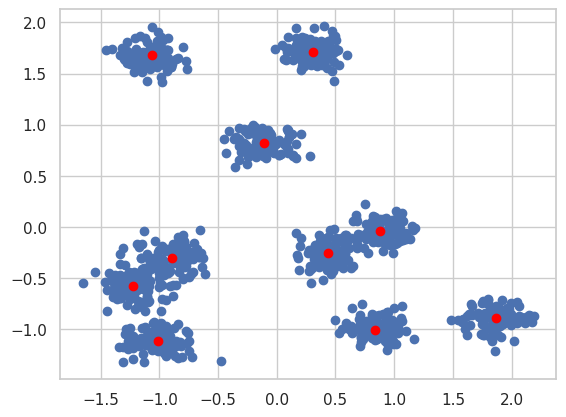

In [22]:
plt.scatter(gmData[:,0], gmData[:,1])
plt.scatter(gmCenters[:,0], gmCenters[:,1], c="red")
plt.show()

In [36]:
random_df = initAlgoMetrics[initAlgoMetrics["initAlgo"]=="RANDOM"]
random_df

,R,initAlgo,initTime,updateTime,seedCost,finalCost,trueCost
0,1,RANDOM,3.034027,74.710596,14.491599,8.570479,8.333528
4,10,RANDOM,1.802900,30.982507,6.961907,3.591477,1.855832
8,100,RANDOM,1.161253,9.324611,6.073774,1.942490,0.215427


In [37]:
plusplus_df = initAlgoMetrics[initAlgoMetrics["initAlgo"]=="KM++"]
plusplus_df

,R,initAlgo,initTime,updateTime,seedCost,finalCost,trueCost
1,1,KM++,0.043638,55.357770,15.536516,8.242110,8.333528
5,10,KM++,0.016795,42.696607,5.997686,3.309632,1.855832
9,100,KM++,0.022390,9.873465,1.985846,0.903400,0.215427


In [38]:
parallel1_df =initAlgoMetrics[initAlgoMetrics["initAlgo"]=="KM|| 0.5"]
parallel1_df

,R,initAlgo,initTime,updateTime,seedCost,finalCost,trueCost
2,1,KM|| 0.5,15.075234,77.748044,13.119863,8.243412,8.333528
6,10,KM|| 0.5,16.804399,44.087146,3.819433,2.455839,1.855832
10,100,KM|| 0.5,10.408533,7.133577,0.274830,0.213319,0.215427


In [39]:
parallel2_df =initAlgoMetrics[initAlgoMetrics["initAlgo"]=="KM|| 2"]
parallel2_df

,R,initAlgo,initTime,updateTime,seedCost,finalCost,trueCost
3,1,KM|| 2,12.254577,38.710560,9.537905,8.487959,8.333528
7,10,KM|| 2,14.694390,19.183839,2.866876,2.690471,1.855832
11,100,KM|| 2,12.165552,6.904361,1.273724,1.238280,0.215427


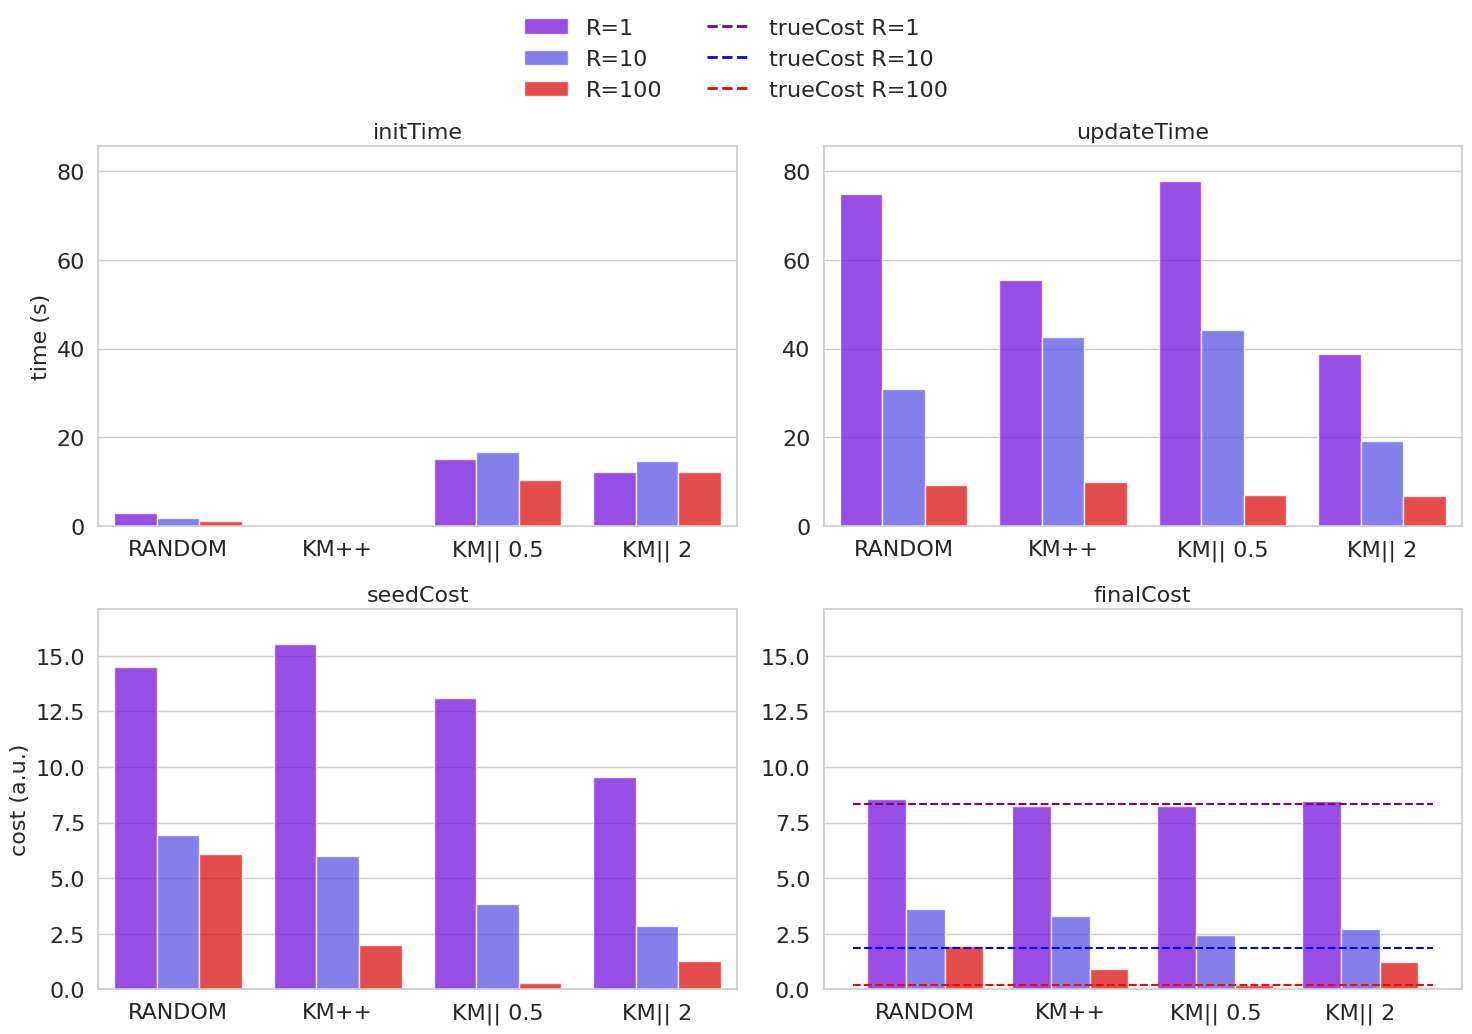

In [233]:
matplotlib.rcParams.update({'font.size': 16})

# Define metrics, units and titles
metrics = ["initTime", "updateTime", "seedCost", "finalCost"]
units = ["time (s)", None, "cost (a.u.)", None]
titles = ["initTime", "updateTime", "seedCost", "finalCost"]

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for ax, metric, title, unit in zip(axs.flat, metrics, titles, units):
    sns.barplot(
        data=initAlgoMetrics,
        x="initAlgo",
        y=metric,
        hue="R",
        palette="rainbow",
        alpha=0.8,
        ax=ax
    )

    # Plot true cost lines
    colors = ["purple", "blue", "red"]  
    labels_true = [f"trueCost R={R}" for R in R_values]
    true_handles = [plt.Line2D([0], [0], color=color, linestyle="dashed", linewidth=2, label=label) for color, label in zip(colors, labels_true)]

    if metric == "finalCost":
        for R, color in zip(R_values, colors):
            val = true_costs_dict[R]
            ax.hlines(val, xmin=-0.5, xmax=3.5, linestyle="dashed", color=color)

    ax.set_xlabel(None, fontsize=16)
    ax.set_ylabel(unit, fontsize=16)
    ax.set_title(title, fontsize=16)
    ax.tick_params(axis="x", labelsize=16)
    ax.tick_params(axis="y", labelsize=16)
    ax.get_legend().remove()

# y-lims
for ax in axs[0, :]:
    ax.set_ylim(0, time_vals.max()*1.1)
for ax in axs[1, :]:
    ax.set_ylim(0, cost_vals.max()*1.1)

# Legend
handles_bar, labels_bar = axs[0,0].get_legend_handles_labels()
labels_bar = [f"R={lab}" for lab in labels_bar]

handles = handles_bar + true_handles
labels = labels_bar + labels_true

fig.legend(
    handles, labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.05),
    ncol=2,
    fontsize=16,
    frameon=False
)

plt.savefig("time_cost_comparison.pdf")
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

## Cost vs. r plots

In [13]:
def collect_costHistory(
    data_rdd: RDD,
    rounds: list[int],
    k: int,
    lk_ratios: list[float],
    iterations: int,
    verbose: bool = False
) -> dict[int, list]:
    costHistory = {}

    for lk_ratio in lk_ratios:
        costHistory[lk_ratio] = []
        for r in rounds:
            if verbose:
                print(f"lk_ratio: {lk_ratio} | rounds: {r}")
            if r==0:
                finalCentroids = kMeansRandom_init(data_rdd, 1)
            else:
                centroids = kMeansParallel_init(data_rdd, k, lk_ratio * k, r)
                finalCentroids = lloydKMeans(data_rdd, centroids, iterations)
            cost = compute_cost(data_rdd, finalCentroids)
            costHistory[lk_ratio].append(cost)
    return costHistory

In [14]:
# --- control parameters --- 
lk_ratios = [0.5, 2, 5] #[0.5, 1, 2, 5, 10]
rounds = [0, 2, 4] #[0, 1, 2, 4, 8, 12, 16]

In [15]:
R = [1, 10, 100]
baselineCosts = []
costHistory = {}
for variance in R:
    print(f"R: {variance}")
    gmData, gmCenters = get_gm(n, k, dim, variance)
    gmData_rdd = sc.parallelize([row for row in gmData], numSlices=16).persist()
    trueCost = compute_cost(gmData_rdd, gmCenters)

    # baseline (KM++ seeds + Lloyd)
    centroids = kMeansPlusPlus_init(gmData, k)
    finalCentroids = lloydKMeans(gmData_rdd, centroids, iterations)
    baselineCosts.append(compute_cost(gmData_rdd, finalCentroids))
    
    costHistory[variance] = collect_costHistory(gmData_rdd, rounds, k, lk_ratios, iterations, verbose = True)

R: 1


lk_ratio: 0.5 | rounds: 0


lk_ratio: 0.5 | rounds: 2


lk_ratio: 0.5 | rounds: 4


lk_ratio: 2 | rounds: 0
lk_ratio: 2 | rounds: 2


lk_ratio: 2 | rounds: 4


lk_ratio: 5 | rounds: 0
lk_ratio: 5 | rounds: 2


lk_ratio: 5 | rounds: 4


R: 10


lk_ratio: 0.5 | rounds: 0
lk_ratio: 0.5 | rounds: 2


lk_ratio: 0.5 | rounds: 4


lk_ratio: 2 | rounds: 0


lk_ratio: 2 | rounds: 2


lk_ratio: 2 | rounds: 4


lk_ratio: 5 | rounds: 0


lk_ratio: 5 | rounds: 2


lk_ratio: 5 | rounds: 4


R: 100


lk_ratio: 0.5 | rounds: 0
lk_ratio: 0.5 | rounds: 2


lk_ratio: 0.5 | rounds: 4


lk_ratio: 2 | rounds: 0
lk_ratio: 2 | rounds: 2


lk_ratio: 2 | rounds: 4


lk_ratio: 5 | rounds: 0


lk_ratio: 5 | rounds: 2


lk_ratio: 5 | rounds: 4


In [234]:
def plot_costHistory(
    costHistory: dict[int, dict[int, list]],
    rounds: list[int],
    baselineCosts: list[float]
) -> None:

    matplotlib.rcParams.update({'font.size': 16})
    
    fig, axs = plt.subplots(1, len(costHistory.keys()), figsize=(18, 6), sharey=True)
    if len(costHistory) == 1:
        axs = [axs]  # Ensure axs is iterable

    for idx, (RR, results) in enumerate(costHistory.items()):
        ax = axs[idx]
        
        # Plot baseline
        ax.axhline(baselineCosts[idx], color='k', linestyle='solid', lw=1.5, alpha=0.7, label="KM++ & Lloyd baseline")
        
        # Colormap
        lk_values = results.keys()
        colors = cm.rainbow(np.linspace(0, 1, len(lk_values)))

        # Markers and linestyles
        markers = ["s", "o", "X"] #["s", "o", "X", "^", "v"]
        lines = ["solid", "dotted", "dashed"] #["solid", "dotted", "dashed", "dashdot", "solid"]

        for lk, color, marker, line in zip(lk_values, colors, markers, lines):
            phis = results[lk]
            ax.plot(rounds, phis, marker=marker, markersize=8, markerfacecolor="none",
                    color=color, linewidth=1.5, linestyle=line, alpha=0.8, label=f"l/k={lk}")

        ax.set_title(f"R = {RR}", fontsize=16)
        ax.set_xlabel("# Initialization Rounds", fontsize=16)
        if idx == 0:
            ax.set_ylabel("Cost", fontsize=16)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.tick_params(axis='x', labelsize=16)
        ax.tick_params(axis='y', labelsize=16)
        ax.legend(frameon=False, fontsize=16)
        ax.grid(alpha=0.6)

    plt.savefig("cost_history_plot.pdf")
    plt.tight_layout()
    plt.show()

    return

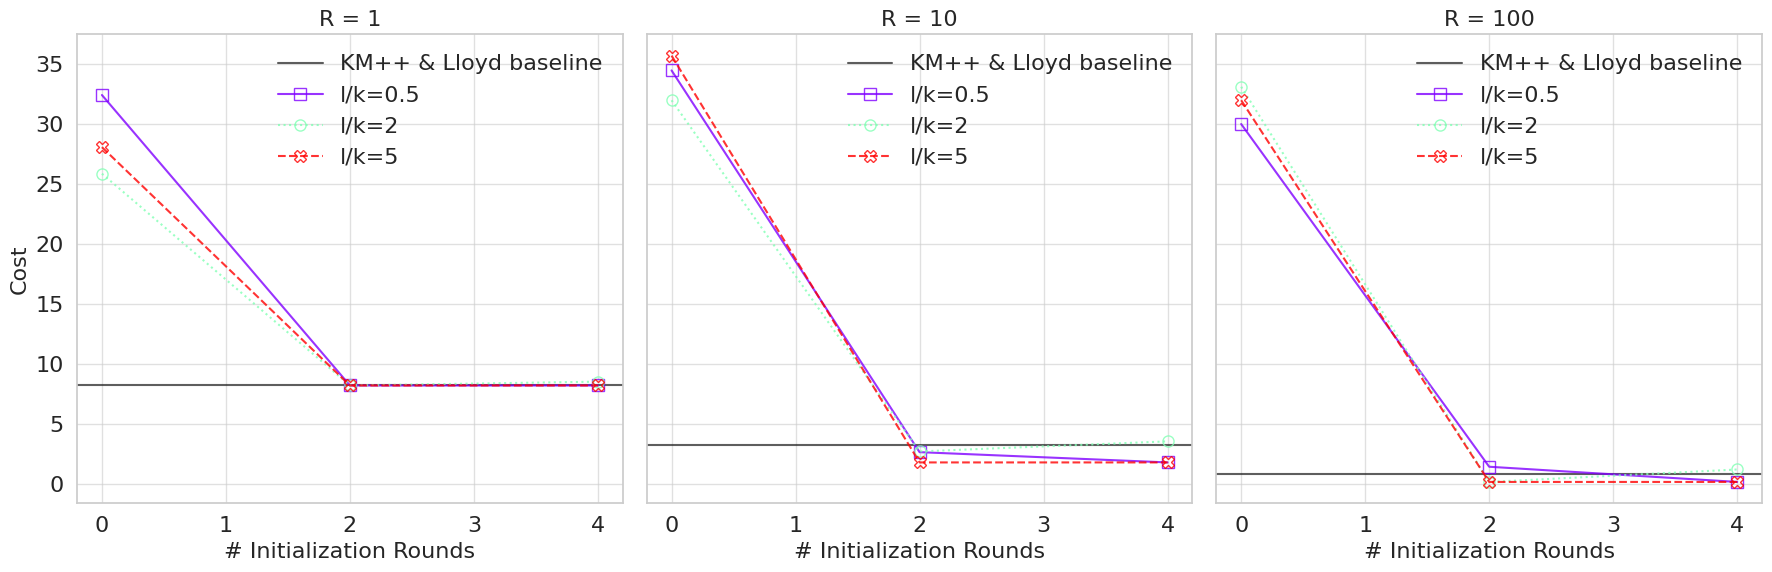

In [235]:
plot_costHistory(costHistory, rounds, baselineCosts)

# Update analysis

In [19]:
kddData, kddLabels, entries_dict = get_kdd(standardize=True)

In [20]:
k = np.unique(kddLabels).shape[0]
l = 0.5 * k

In [21]:
kddData_rdd = sc.parallelize([row for row in kddData]).persist()
centroids = kMeansParallel_init(kddData_rdd, k, l)
kddData_rdd.unpersist()

ERROR:root:KeyboardInterrupt while sending command.                 (0 + 8) / 8]
Traceback (most recent call last):
  File "/usr/bin/spark-3.5.5-bin-hadoop3/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/bin/spark-3.5.5-bin-hadoop3/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/socket.py", line 718, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt
                                                                                

KeyboardInterrupt: 

In [ ]:
time_dict = {}

Lloyd's kMeans serial

In [ ]:
start_time = time.time()
final_centroids = lloydKMeans(kddData, centroids, iterations = 100)
delta_time = time.time() - start_time
time_dict[1] = {"lloyd": delta_time}

Parallel

In [ ]:
partitions = [2, 4, 8, 16, 32, 64, 128]
for numSlices in partitions:
    time_dict[numSlices] = {}
    kddData_rdd = sc.parallelize([row for row in kddData], numSlices=numSlices).persist()
    
    start_time = time.time()
    final_centroids = lloydKMeans(kddData_rdd, centroids, iterations = 100)
    delta_time = time.time() - start_time
    time_dict[numSlices]["lloyd"] = delta_time

    start_time = time.time()
    final_centroids = miniBatchKMeans(kddData_rdd, centroids, iterations = 100)
    delta_time = time.time() - start_time
    time_dict[numSlices]["miniBatch"] = delta_time
    
    kddData_rdd.unpersist()

In [ ]:
time_dict

### Cost vs iterations


In [ ]:
max_epochs = 200

# final results dictionary
results_dict = {
    "lloyd_serial": [],
    "lloyd_parallel": [],
    "minibatch_01": [],
    "minibatch_02": [],
    "minibatch_05": [],
    "minibatch_07": []
}

# partial_results
patience = 3        # number of previous costs to average for stopping
threshold = 1e-3    # convergence threshold

# Parameters
n_runs = 3  # number of independent runs
all_histories_runs = {key: [] for key in results_dict.keys()}

In [ ]:
for key in results_dict.keys():
    print(f"Running {key}")

    for run in range(n_runs):
        print(f"  Run {run+1}/{n_runs}")
        history = []

        current_centroids = centroids.copy()  # initialize centroids

        # compute initial cost
        if key.startswith("minibatch") or key == "lloyd_parallel":
            initial_cost = compute_cost(kddData_rdd, current_centroids)
        else:  # lloyd_serial
            initial_cost = compute_cost(kddData_rdd, current_centroids)
        history.append(initial_cost)

        # compute costs for each epoch
        for epoch in range(max_epochs):
            if key == 'lloyd_serial':
                current_centroids = lloydKMeans(kddData_rdd, centroids=current_centroids, iterations=1)
                cost = compute_cost(kddData_rdd, current_centroids)
            elif key == "lloyd_parallel":
                current_centroids = lloydKMeans(kddData_rdd, centroids=current_centroids, iterations=1)
                cost = compute_cost(kddData_rdd, current_centroids)
            elif key.startswith("minibatch"):
                fraction = {
                    "minibatch_01": 0.1,
                    "minibatch_02": 0.2,
                    "minibatch_05": 0.5,
                    "minibatch_07": 0.7,
                }[key]

                current_centroids = miniBatchKMeans(
                    kddData_rdd, centroids=current_centroids, iterations=1, batch_fraction=fraction
                )
                cost = compute_cost(kddData_rdd, current_centroids)

            history.append(cost)

            # early stopping: compare current cost to average of last `patience` costs
            if len(history) > patience:
                recent_avg = np.mean(history[-patience:])
                if abs(history[-1] - recent_avg) < threshold:
                    break

        # pad history to max_epochs
        if len(history) < max_epochs + 1:  # +1 because of initial cost
            history += [history[-1]] * ((max_epochs + 1) - len(history))

        all_histories_runs[key].append(history)

In [ ]:
# Compute mean and std for each algorithm
results_mean_std = {}
for key, histories in all_histories_runs.items():
    arr = np.array(histories)  # shape: (n_runs, max_epochs+1)
    mean_cost = arr.mean(axis=0)
    std_cost = arr.std(axis=0)
    results_mean_std[key] = {"mean": mean_cost, "std": std_cost}

In [ ]:
results_dict

In [ ]:
results_mean_std

In [ ]:
plt.figure(figsize=(12, 6))

# different markers
markers = ['o', 's', '^', 'D', 'x', '*']

# offsets to avoid errorbar overlaps
offsets = [0,1,0,0,1,-1]
for i, (key, stats) in enumerate(results_mean_std.items()):
    mean = stats["mean"]
    std = stats["std"]
    epochs = np.arange(len(mean))

    # line style
    if "lloyd" in key:
        line_style = "--"   
    else:
        line_style = "-"    

    # cycle markers
    marker = markers[i]
    
    plt.errorbar(
        epochs[::10+offsets[i]], mean[::10+offsets[i]], yerr=std[::10+offsets[i]],
        fmt=line_style+marker, capsize=3, label=key
    )
    offset += 1

plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Cost", fontsize=14)
plt.title("K-Means Convergence: Cost vs Epochs", fontsize=16)
plt.grid(alpha=0.6)
plt.legend(title="Algorithm:", loc="best")
plt.show()

Stopping the cluster

In [ ]:
sc.stop()
spark.stop()

In [ ]:
"""# stopping the cluster
! $SPARK_HOME/sbin/stop-all.sh
# clearing the `$SPARK_HOME/work` directory in all the nodes
# this avoids cluttering of storage among nodes
! rm -rf $SPARK_HOME/work/*
! ssh worker1 "rm -rf $SPARK_HOME/work/*"
! ssh worker2 "rm -rf $SPARK_HOME/work/*"
! ssh worker3 "rm -rf $SPARK_HOME/work/*""""

In [42]:
time_dict = {
    1: {'lloyd': 17.238966464996338},
    2: {'lloyd': 34.04286217689514, 'miniBatch': 12.04980731010437},
    4: {'lloyd': 17.933119535446167, 'miniBatch': 8.075101613998413},
    8: {'lloyd': 10.722455978393555, 'miniBatch': 5.795122861862183},
    16: {'lloyd': 8.191429376602173, 'miniBatch': 5.853504419326782},
    32: {'lloyd': 10.909662961959839, 'miniBatch': 6.993889093399048},
    64: {'lloyd': 12.047245025634766, 'miniBatch': 9.350556135177612},
    128: {'lloyd': 17.013242483139038, 'miniBatch': 13.624184846878052}
}

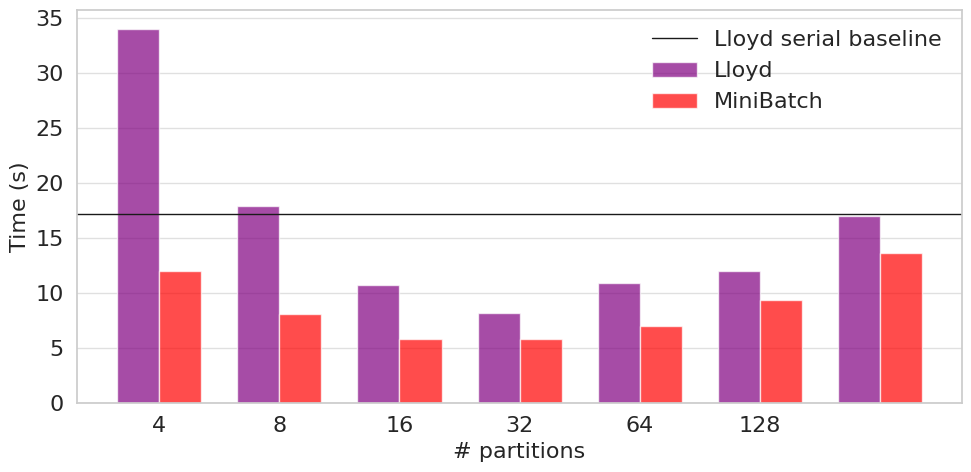

In [228]:
# Partition vs time plot
keys = [k for k in time_dict.keys() if k != 1] 
lloyd_values = [time_dict[k]['lloyd'] for k in keys]
minibatch_values = [time_dict[k]['miniBatch'] for k in keys]

x = np.arange(len(keys))

matplotlib.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(x - width/2, lloyd_values, 0.35, label='Lloyd', color="purple", alpha=0.7)
ax.bar(x + width/2, minibatch_values, 0.35, label='MiniBatch', color="red", alpha=0.7)

# Baseline
ax.axhline(time_dict[1]['lloyd'], color='k', linestyle="solid", linewidth=1, label="Lloyd serial baseline")

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_xticklabels(keys)
ax.set_xlabel("# partitions", fontsize=16)
ax.set_ylabel("Time (s)", fontsize=16)
ax.legend(frameon=False, fontsize=16)

plt.grid(None)
ax.grid(axis="y", alpha=0.6)

plt.savefig("partition_plot.pdf")
plt.tight_layout()
plt.show()